# Analyzing frames

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import easyocr
import face_recognition
from tqdm.auto import tqdm

In [2]:
abo16_list = pd.read_csv("../data/abo16_list.txt")
# lang_map = lang_map.loc[~lang_map.filename.str.contains("c5008-22"), :]

In [3]:
abo16_list

,filename,lang
0,c5008-2201151100.mp4,Seediq
1,c5008-2201150800.mp4,Thau
2,c5008-2201142000.mp4,Saysiyat
3,c5008-2201141100.mp4,Rukai
4,c5008-2201132000.mp4,Bunun
...,...,...
139,c5008-2110212000.mp4,Bunun
140,c5008-2110202000.mp4,Sakizaya
141,c5008-2110192000.mp4,Yami
142,c5008-2110172000.mp4,Pinuyumayan


In [4]:
def make_video_path(video_name):
    video_dir = Path("../data/videos")
    date_dir = video_name.split("-")[1].replace(".mp4", "")
    video_path = video_dir / date_dir / video_name
    return video_path

In [5]:
ocr = easyocr.Reader(['en', 'ch_tra'])
font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 36)
font_ocr = ImageFont.truetype("../data/NotoSansTC-Regular.otf", 16)

In [6]:
def snapshot(video, offsets=None):        
    fps = video.get(cv2.CAP_PROP_FPS)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    if offsets is None:
        offsets = [25]        
    
    for idx, offset_x in enumerate(offsets):
        video.set(cv2.CAP_PROP_POS_FRAMES, int(offset_x * fps))
        ok, im = video.read()    
        if not ok:
            raise IOError("Error when reading video")        
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)                
        yield im
    return

In [41]:
def process_frame(im_arr, anchor_enc=None, anchor_name=None):
    im = Image.fromarray(im_arr)            
    ocr_results = ocr.readtext(im_arr)
    anchor_text = [x for x in ocr_results if x[1].startswith("主播")]    
    if anchor_text:
        anchor_idx = ocr_results.index(anchor_text[0])
        if len(anchor_text[0][1]) > 2:
            anchor_ocr_entry = anchor_text[0]            
            anchor_name = anchor_ocr_entry[1][2:].strip()
        elif anchor_idx+1 < len(ocr_results):
            anchor_label_bb = ocr_results[anchor_idx][0]
            anchor_name_bb = ocr_results[anchor_idx+1][0]
            # check they are beside each other horizontally
            if (anchor_name_bb[0][0] - anchor_label_bb[1][0] < 40 and 
                anchor_name_bb[0][1] - anchor_label_bb[1][1] < 10):
                anchor_name = ocr_results[anchor_idx+1][1]
            else:
                anchor_name = "(NA)"
        
    ## try find headline
    imH, imW, _ = im_arr.shape
    headline_text = [x for x in ocr_results 
                     if ((x[0][1][0] - x[0][0][0] > imW * .5) and
                         (x[0][0][1] > imH * .75))]
    if headline_text:
        # sorted by width
        headline_text = sorted(headline_text, 
                               key=lambda x: x[0][1][0]-x[0][0][0], 
                               reverse=True)[0][1]
    else:
        headline_text = ""
    faces = face_recognition.face_locations(im_arr)    
    only_one_face = len(faces) == 1
    is_anchor = anchor_text and only_one_face
    ret = {"faces": faces, "ocr":ocr_results, "has_anchor": False}
    # build anchor face encoding
    if is_anchor and anchor_enc is None:
        face_enc = face_recognition.face_encodings(im_arr, faces)
        ret.update(dict(has_anchor=True, 
                        anchor_enc=face_enc, anchor_name=anchor_name,
                        headline=headline_text))
    elif anchor_enc is not None:
        face_encs = face_recognition.face_encodings(im_arr, faces)        
        face_hits = face_recognition.compare_faces(np.array(face_encs), np.array(anchor_enc))        
        has_anchor = any(face_hits) and headline_text
        ret.update(dict(has_anchor=has_anchor, 
                        anchor_enc=anchor_enc, anchor_name=anchor_name,
                        headline=headline_text))
    else:
        pass
    return ret            

In [42]:
def annotate_image(im_arr, proc_data=None):
    if proc_data is None:
        proc_data = process_frame(im_arr)
    im = Image.fromarray(im_arr)        
    faces = proc_data["faces"]
    ocr_results = proc_data["ocr"]
    draw = ImageDraw.Draw(im)    
    for face_x in faces:
        t,r,b,l = face_x        
        draw.rectangle([(l,t),(r,b)], outline="orange", width=4)
    
    for ocr_x in ocr_results:
        tl, _, br, _ = ocr_x[0]
        text = ocr_x[1]
        conf = ocr_x[2]
        tw, th = font_ocr.getsize(text)
        draw.rectangle([tuple(tl), tuple(br)], outline='blue', width=2)
        draw.rectangle([(tl[0], tl[1]-th), (tl[0]+tw, tl[1])], fill='blue', width=2)
        draw.text([tl[0], tl[1]-th], text, font=font_ocr)
    return im

In [30]:
video_name = abo16_list.filename[1]
video_path = make_video_path(video_name)
video_reader = cv2.VideoCapture(str(video_path))
imgs = list(snapshot(video_reader, [25,28,30]))

In [43]:
process_frame(imgs[0])

{'faces': [(223, 354, 331, 247)],
 'ocr': [([[149, 81], [237, 81], [237, 119], [149, 119]],
   'TTV',
   0.6595162583013097),
  ([[127, 441], [560, 441], [560, 483], [127, 483]],
   '主播 kurali Lhkashnawanan',
   0.9207369126132123),
  ([[743, 513], [1167, 513], [1167, 573], [743, 573]],
   '歡迎收看邵族族語新聞',
   0.9826465874628636),
  ([[125, 571], [209, 571], [209, 611], [125, 611]],
   'Thau',
   0.9999969005584717),
  ([[123, 615], [249, 615], [249, 657], [123, 657]],
   '間新置',
   0.003443430583081749),
  ([[141, 657], [253, 657], [253, 677], [141, 677]],
   'TPCF.1|TV',
   0.0613996965782639)],
 'has_anchor': True,
 'anchor_enc': [array([-0.13705115,  0.08346476,  0.07680515, -0.04138728, -0.1314078 ,
          0.02132883, -0.0668291 , -0.15425405,  0.1591357 , -0.17024699,
          0.17917414, -0.0215545 , -0.17593905, -0.00385593,  0.01025754,
          0.20446399, -0.10801805, -0.14238079, -0.03392705,  0.0354116 ,
         -0.03436649,  0.00473476,  0.09821732,  0.02966858, -0.16216

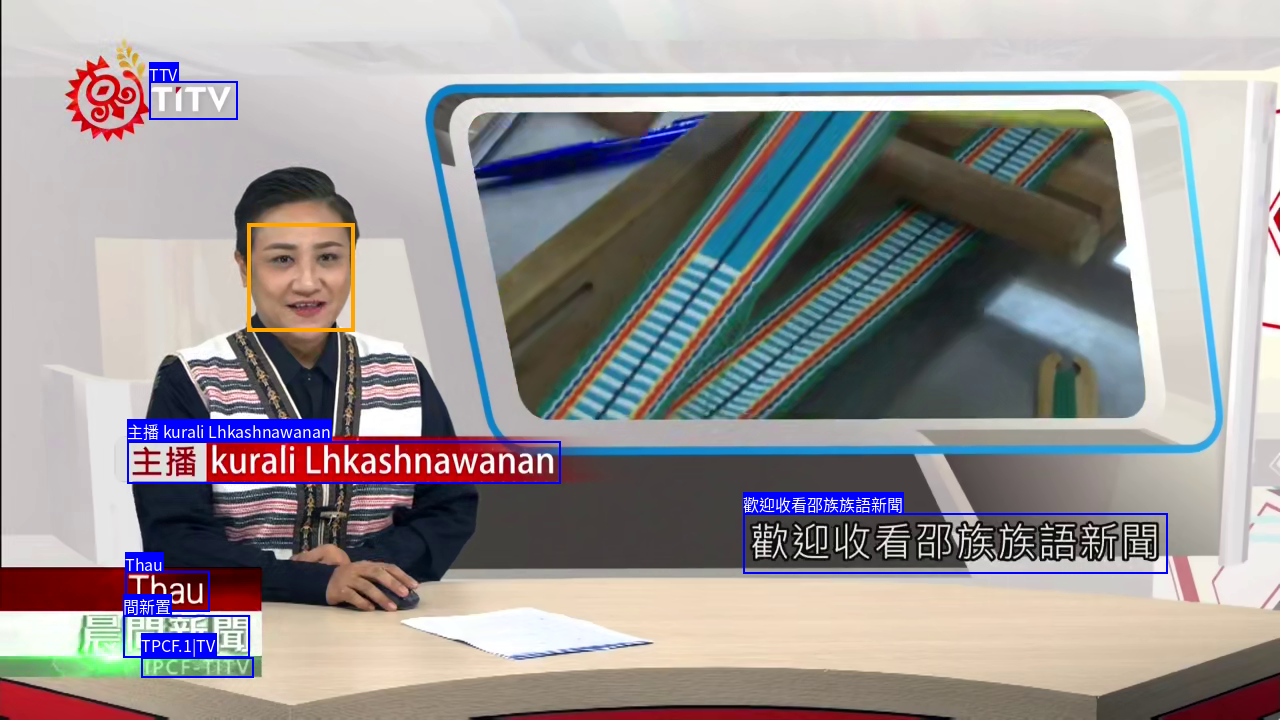

In [44]:
annotate_image(imgs[0])

In [45]:
def analyze_segment(video_reader, start_sec, end_sec, step, anchor_enc=None, anchor_name=None):
    anchor_frame = []    
    offsets = np.arange(start_sec, end_sec, step)
    imgs = snapshot(video_reader, offsets)    
    if len(offsets) >= 10:
        pbar = tqdm(total=len(offsets))
    else:
        pbar = None
        
    for img_i, (img_offset, img_x) in enumerate(zip(offsets, imgs)):
        if pbar: pbar.update(1)
        proc_img = process_frame(img_x, 
                                 anchor_enc=anchor_enc, 
                                 anchor_name=anchor_name)
        anchor_enc = anchor_enc or proc_img.get("anchor_enc")
        anchor_name = anchor_name or proc_img.get("anchor_name")
        headline = proc_img.get("headline")
        if proc_img["has_anchor"]:
            anchor_frame.append((img_offset, True, anchor_name, headline))        
        else:
            anchor_frame.append((img_offset, False, '', ''))
    if pbar: pbar.close()
    return anchor_frame, anchor_enc, anchor_name

In [46]:
def analyze_video(video_reader, start=20, end=3500, min_seg=1, max_seg=20):    
    seg, anchor_enc, anchor_name = analyze_segment(
                        video_reader, start, start+20, step=1) 
    buf = [(start+20, end, max_seg)]
    segments = seg
    pbar = tqdm()    
    counter = 0
    while buf:
        start, end, step = buf.pop()
        pbar.update(1)
        pbar.set_description(f"{start}->{end} ({step})")    
        seg, anchor_enc, anchor_name = analyze_segment(video_reader, start, end, step, 
                                                     anchor_enc, anchor_name)            
        segments.extend(seg)
        segments = sorted(segments, key=lambda x: x[0])
        seg2_offsets = [(x[0],y[0]) for x, y in zip(segments, segments[1:]) if y[1] or x[1]]                
        
        seg2_list = []
        for seg_x in seg2_offsets:
            ss, ee = seg_x
            if ee-ss <= min_seg: continue
            step2 = (ee-ss)//2
            seg2_list.append((ss+step2, ee, step2))
            break
        buf = seg2_list              
    else:
        pbar.close()    
    return segments

## Main Loop

In [49]:
# thau_list = abo16_list.loc[abo16_list.lang=='Thau']
paiwan_list = abo16_list.loc[abo16_list.lang=='Paiwan']

In [51]:
sandbox_dir = Path("../data/sandbox/anchor_segs")
sandbox_dir.mkdir(parents=True, exist_ok=True)

# for video_idx, video_name in enumerate(abo16_list.filename):
for video_idx, video_name in enumerate(paiwan_list.filename):
    print(f"{video_idx}/{abo16_list.shape[0]}: {video_name}")
    csv_path = sandbox_dir/video_name.replace(".mp4", ".anchor.csv")
    # if csv_path.exists():
    #     continue    
    video_path = make_video_path(video_name)
    video_reader = cv2.VideoCapture(str(video_path))
    # segments = analyze_video(video_reader, start=20, end=1000, min_seg=5, max_seg=20)
    segments = analyze_video(video_reader, start=20, end=3300, min_seg=5, max_seg=20)
    seg_dfr = pd.DataFrame.from_records(segments, columns="offset is_anchor anchor_name headline".split())
    seg_dfr.to_csv(csv_path)

0/144: c5008-2201082000.mp4


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

1/144: c5008-2201012000.mp4


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

2/144: c5008-2112252000.mp4


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

3/144: c5008-2112112000.mp4


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

4/144: c5008-2111272000.mp4


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

5/144: c5008-2111202000.mp4


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

6/144: c5008-2111132000.mp4


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

7/144: c5008-2111062000.mp4


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

8/144: c5008-2110302000.mp4


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]